# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

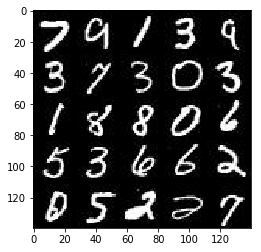

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

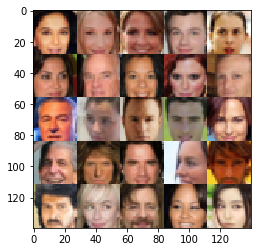

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels),name='input_real')
    input_z= tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.1 * layer1, layer1)
        # 14x14x32
        
        layer2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(0.1 * layer2, layer2)
        # 7x7x64
        
        layer3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(0.1 * layer3, layer3)
        # 4x4x128

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        layer1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(0.1 * layer1, layer1)
        # 7x7x512 now
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(0.1 * layer2, layer2)
        # 14x14x256 now
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=1, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(0.1 * layer3, layer3)
        # 14x14x128 now
        
        layer4 = tf.layers.conv2d_transpose(layer3, 64, 5, strides=1, padding='same')
        layer4 = tf.layers.batch_normalization(layer4, training=is_train)
        layer4 = tf.maximum(0.1 * layer4, layer4)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(layer4, out_channel_dim, 3, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, input_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                
                if steps % 10 == 0 or steps == 1:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0 or steps == 1:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 7.5432... Generator Loss: 0.0006


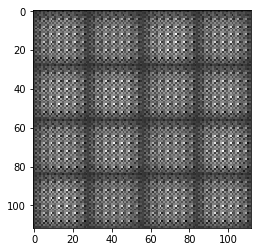

Epoch 1/2... Discriminator Loss: 0.1057... Generator Loss: 3.0347
Epoch 1/2... Discriminator Loss: 0.2971... Generator Loss: 2.3112
Epoch 1/2... Discriminator Loss: 1.5067... Generator Loss: 0.4279
Epoch 1/2... Discriminator Loss: 0.5811... Generator Loss: 3.0472
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 1.9111
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.1436
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 1.2906
Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 0.7357
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 1.0220
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 1.0769


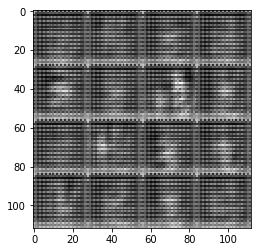

Epoch 1/2... Discriminator Loss: 1.5515... Generator Loss: 0.3589
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 0.5750
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 1.2589
Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 0.8362
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 1.0744... Generator Loss: 0.8498
Epoch 1/2... Discriminator Loss: 1.6395... Generator Loss: 2.1405
Epoch 1/2... Discriminator Loss: 1.0730... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 1.1212


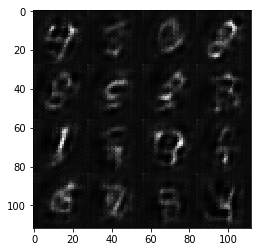

Epoch 1/2... Discriminator Loss: 1.2285... Generator Loss: 0.5298
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 0.8209
Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 1.1483... Generator Loss: 0.7132
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 0.5396
Epoch 1/2... Discriminator Loss: 1.1862... Generator Loss: 0.6740
Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 0.8982
Epoch 1/2... Discriminator Loss: 1.3440... Generator Loss: 0.4561
Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 0.9996
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.5918


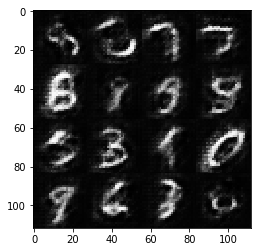

Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 0.7670
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 1.0307
Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.4934
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 0.6205
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 0.7431
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 0.6298
Epoch 1/2... Discriminator Loss: 1.4955... Generator Loss: 0.3668
Epoch 1/2... Discriminator Loss: 1.5093... Generator Loss: 0.3678
Epoch 1/2... Discriminator Loss: 1.2030... Generator Loss: 0.7499
Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.3813


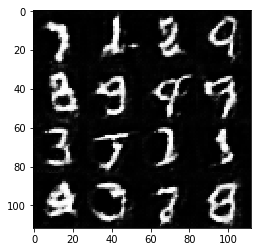

Epoch 1/2... Discriminator Loss: 1.3209... Generator Loss: 0.6367
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.4505
Epoch 1/2... Discriminator Loss: 1.5684... Generator Loss: 0.3162
Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 0.8058
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.4505
Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 1.1536
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 1.0379
Epoch 1/2... Discriminator Loss: 1.2534... Generator Loss: 0.6825
Epoch 1/2... Discriminator Loss: 1.1807... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 1.2916


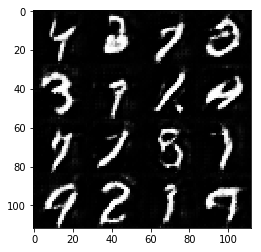

Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 0.6181
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.4914
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.4086
Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.2074... Generator Loss: 0.8035
Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 1.1798
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.4567
Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 0.6712
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.8225


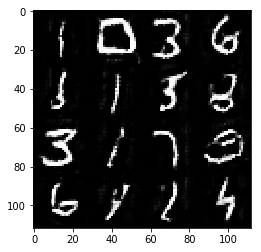

Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.4778
Epoch 2/2... Discriminator Loss: 1.0768... Generator Loss: 1.1327
Epoch 2/2... Discriminator Loss: 1.1410... Generator Loss: 0.6580
Epoch 2/2... Discriminator Loss: 1.2320... Generator Loss: 0.6967
Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 1.1476
Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 0.7101
Epoch 2/2... Discriminator Loss: 1.1564... Generator Loss: 0.8819
Epoch 2/2... Discriminator Loss: 1.0975... Generator Loss: 1.1394
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.6661
Epoch 2/2... Discriminator Loss: 1.3367... Generator Loss: 0.5154


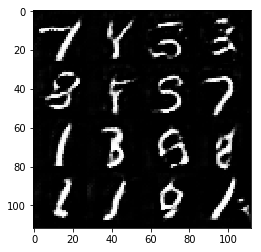

Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.5853
Epoch 2/2... Discriminator Loss: 1.2662... Generator Loss: 0.6874
Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: 1.1762... Generator Loss: 0.6963
Epoch 2/2... Discriminator Loss: 1.3488... Generator Loss: 0.4404
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.4398
Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.6310
Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 0.6734
Epoch 2/2... Discriminator Loss: 1.2297... Generator Loss: 0.9691


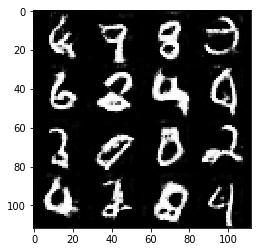

Epoch 2/2... Discriminator Loss: 1.3121... Generator Loss: 0.5212
Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 1.4429
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 1.0675
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.5006
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 1.2494
Epoch 2/2... Discriminator Loss: 1.1157... Generator Loss: 0.6590
Epoch 2/2... Discriminator Loss: 2.1065... Generator Loss: 0.1764
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.7630


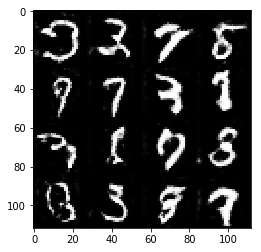

Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 1.0261
Epoch 2/2... Discriminator Loss: 1.2169... Generator Loss: 0.6684
Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 0.5979
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 0.6843
Epoch 2/2... Discriminator Loss: 1.2430... Generator Loss: 0.6750
Epoch 2/2... Discriminator Loss: 1.1492... Generator Loss: 0.8894
Epoch 2/2... Discriminator Loss: 1.5319... Generator Loss: 0.3542
Epoch 2/2... Discriminator Loss: 1.3298... Generator Loss: 0.4883
Epoch 2/2... Discriminator Loss: 1.2207... Generator Loss: 0.6662


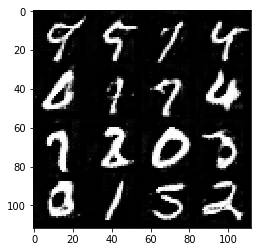

Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 0.7455
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 0.7079
Epoch 2/2... Discriminator Loss: 1.1893... Generator Loss: 0.6452
Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 1.0137
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.7609
Epoch 2/2... Discriminator Loss: 1.7195... Generator Loss: 1.9312
Epoch 2/2... Discriminator Loss: 1.1566... Generator Loss: 0.7398
Epoch 2/2... Discriminator Loss: 1.3985... Generator Loss: 0.5165
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 0.4902


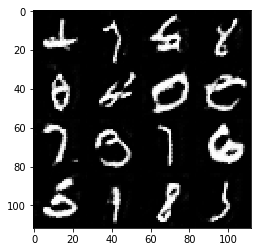

Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 1.6285... Generator Loss: 0.3692
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 1.4267... Generator Loss: 1.9522
Epoch 2/2... Discriminator Loss: 1.1086... Generator Loss: 1.0974
Epoch 2/2... Discriminator Loss: 1.1326... Generator Loss: 0.9934
Epoch 2/2... Discriminator Loss: 1.7530... Generator Loss: 0.2717
Epoch 2/2... Discriminator Loss: 1.1491... Generator Loss: 0.8445
Epoch 2/2... Discriminator Loss: 1.1965... Generator Loss: 0.5992
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 1.0933


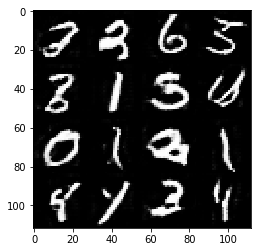

In [13]:
batch_size = 100
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.8411... Generator Loss: 0.0110


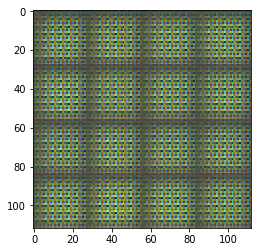

Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 7.3216
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 2.0465
Epoch 1/1... Discriminator Loss: 3.5767... Generator Loss: 0.1046
Epoch 1/1... Discriminator Loss: 1.7778... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 2.1038... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 0.7389


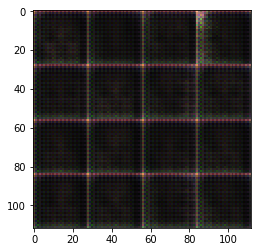

Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.7471... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.5884... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6890


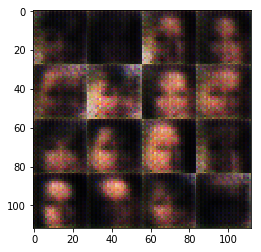

Epoch 1/1... Discriminator Loss: 1.9191... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.5423... Generator Loss: 0.6754


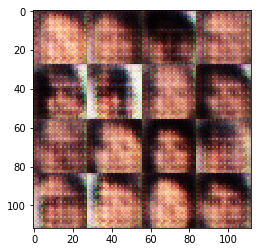

Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.9148


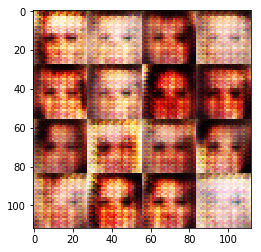

Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.8829... Generator Loss: 1.2733
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 1.4816
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.8247


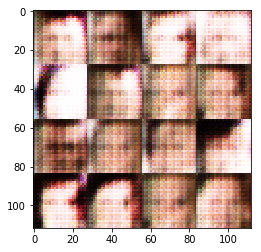

Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.6306... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 1.2624
Epoch 1/1... Discriminator Loss: 1.6554... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.7671


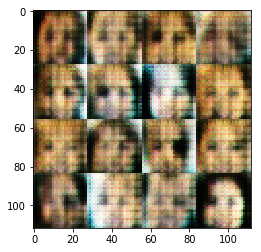

Epoch 1/1... Discriminator Loss: 1.6653... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7377


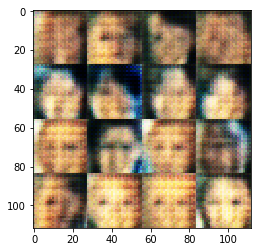

Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.8495


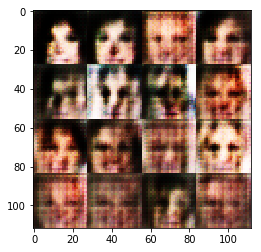

Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8121


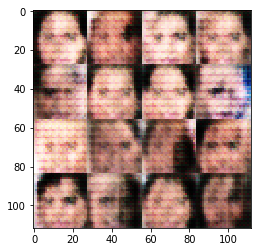

Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.6108... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.8164


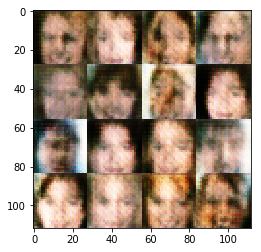

Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.9326


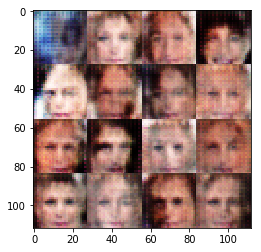

Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.8156


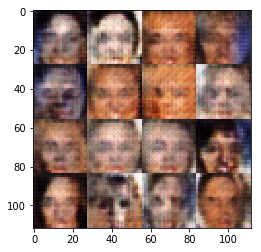

Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 1.6182... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.5625


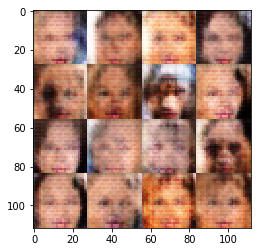

Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.7552


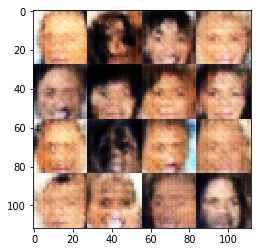

Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.6655


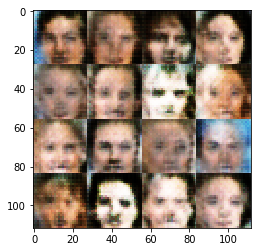

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 1.0051


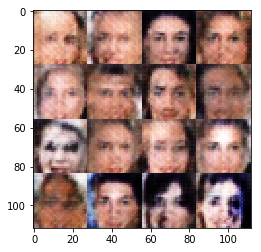

Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 1.0305
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.6309


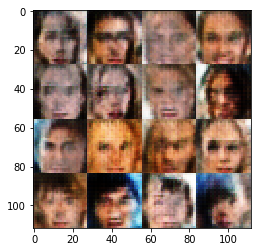

Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.6311


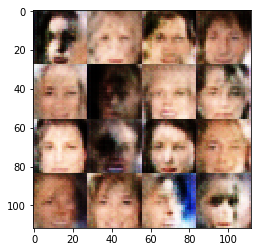

Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.9134


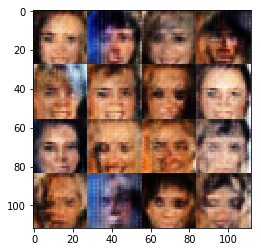

Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.5368


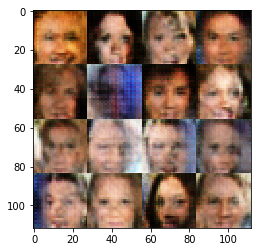

Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.5103


In [14]:
batch_size = 100
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.